In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from nxviz import MatrixPlot, ArcPlot, CircosPlot
from hiveplot import HivePlot
import statsmodels.api as sm

%matplotlib inline

<h1>Loading datasets</h1>
<p>There are different file formats for storing network data and in most cases these data are divided into two files: one file contains edges and their attributes while the other contains nodes and their attributes.<br>
When loading the dataset, you have to decide which class of graphs to use based on the network structure you want to represent.
</p>
<p>
Networkx provides the following classes:
<ul>
<li> Graph: undirected graphs with self loops </li>
<li> DiGraph: directed graphs with self loops </li>
<li> MultiGraph: undirected graphs with self loops and parallel edges </li>
<li> MultiDiGraph: directed graphs with self loops and parallel edges </li>
<li> OrderedGraphs: consistently ordered graphs </li>
</ul>
</p>
<a href="http://konect.uni-koblenz.de/networks/moreno_seventh"><h2>Seventh graders dataset</h2></a>
<p>This directed network contains proximity ratings between students from 29 seventh grade students from a school in Victoria. Among other questions the students were asked to nominate their preferred classmates for three different activities. A node represents a student. An edge between two nodes shows that the left student picked the right student as his answer. The edge weights are between 1 and 3 and show how often the left student chose the right student as his favourite.</p>

In [2]:
# Read the edge list
df = pd.read_csv('data/out.moreno_seventh_seventh', skiprows=2, header=None, sep=' ')
df.columns = ['student1', 'student2', 'count']

# Read the node metadata
nodeAttributes = pd.read_csv('data/ent.moreno_seventh_seventh.student.gender',header=None)
nodeAttributes.index += 1
nodeAttributes.columns = ['gender']
    
# Construct graph from edge list.
G = nx.DiGraph()
for row in df.iterrows():
    G.add_edge(row[1]['student1'], row[1]['student2'], count=row[1]['count'])
    
# Add node attributes
for n in G.nodes():
    (G.nodes[n])['gender'] = nodeAttributes.iloc[n-2]['gender']

print(nx.info(G))

Name: 
Type: DiGraph
Number of nodes: 29
Number of edges: 376
Average in degree:  12.9655
Average out degree:  12.9655


<h3>Basic operations</h3>

In [3]:
len(list(G.nodes(data=True)))

29

<h1>Graph visualization</h1>
<p>Often if the network is large, visualizations begin to look like <b>hairballs</b> and you can not get any useful information about its features. <br> So there are other ways to visualize networks following a <b>rational visualization approach</b>: arc plots, circus plots and hive plots. <br> The principle behind <b>rational visualization</b> is to prioritize the placement of nodes in a certain way and then look at the edges and how they are structured according to the organization of the nodes.</p>

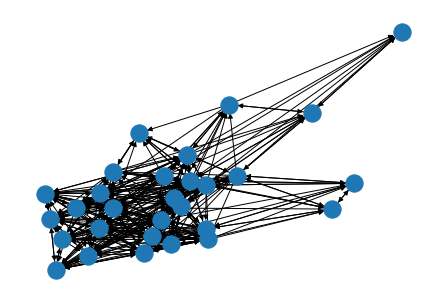

In [4]:
nx.draw(G)

<h2>Arc plot</h2>
<p>In arc diagrams, nodes are displayed along a single axis and links are represented with arcs.<br> It can <b>highlight clusters</b> quite well if the node order is optimized.<br>Nodes can be grouped or ordered by a criteria in order to visualize the <b>density</b> of the connections between groups.</p>

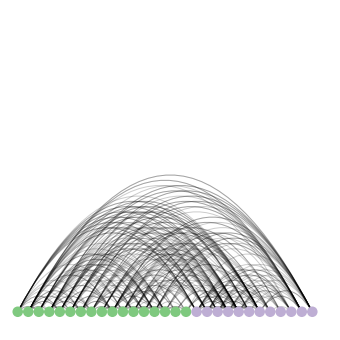

In [5]:
a = ArcPlot(G, node_color='gender', node_grouping='gender')
a.draw()

<h2>Circos plot</h2>
<p>This visualization helps us highlight nodes that there are poorly connected, and others that are strongly connected.</p>

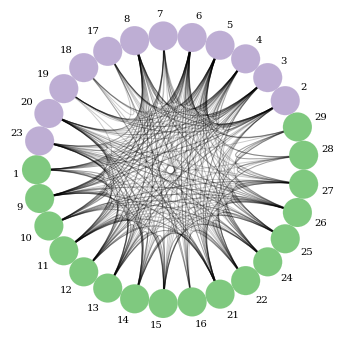

In [6]:
c = CircosPlot(G, node_color='gender', node_grouping='gender', node_labels=True)
c.draw()

<h2>Hiveplots</h2>
<p>Hive plots allow us to divide our nodes into sub-groups, and visualize the within- and between-group connectivity.</p>

In [7]:
from hiveplot import HivePlot

nodes = dict()
nodes['male'] = [n for n,d in G.nodes(data=True) if d['gender'] == 'male']
nodes['female'] = [n for n,d in G.nodes(data=True) if d['gender'] == 'female']

edges = dict()
edges['group1'] = G.edges(data=True)

nodes_cmap = dict()
nodes_cmap['male'] = 'blue'
nodes_cmap['female'] = 'red'

edges_cmap = dict()
edges_cmap['group1'] = 'black'

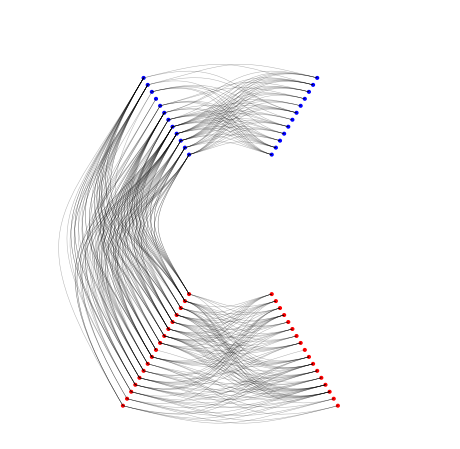

In [8]:
h = HivePlot(nodes, edges, nodes_cmap, edges_cmap)
h.draw()

<h1>Centrality measures</h1>

<p>The centrality measures are used to identify and classify the most important nodes in the network.<br>Some of the applications are finding the most influential people in a social network or identifying the super spreaders of a disease.</p>

<a href="http://konect.uni-koblenz.de/networks/moreno_train"><h2>Train bombing dataset</h2></a>
<p>This undirected network contains contacts between suspected terrorists involved in the train bombing of Madrid on March 11, 2004 as reconstructed from newspapers. A node represents a terrorist and an edge between two terrorists shows that there was a contact between the two terroists. The edge weights denote how 'strong' a connection was. This includes friendship and co-participating in training camps or previous attacks.</p>

In [9]:
df = pd.read_csv('data/out.moreno_train_train', skiprows=2, header=None, sep=' ')
df.columns = ['terrorist1', 'terrorist2','weight']
G = nx.from_pandas_edgelist(df, source='terrorist1', target='terrorist2',edge_attr='weight')
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 64
Number of edges: 243
Average degree:   7.5938


<p>We can see with the following visualization which are the most influential and active terrorists.</p>

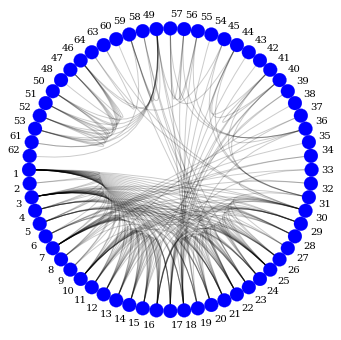

In [10]:
c = CircosPlot(G, node_labels=True)
c.draw()

In [11]:
sorted(G.nodes(),key=lambda x:len(list(G.neighbors(x))), reverse=True)[0:5]

[1, 3, 7, 10, 25]

In [12]:
sorted(nx.degree_centrality(G).items(), key=lambda x: x[1], reverse=True)[:5]

[(1, 0.4603174603174603),
 (3, 0.42857142857142855),
 (7, 0.3492063492063492),
 (10, 0.2857142857142857),
 (25, 0.2698412698412698)]

In [13]:
sorted(nx.closeness_centrality(G).items(), key=lambda x: x[1], reverse=True)[:5]

[(1, 0.5833333333333334),
 (3, 0.5727272727272728),
 (25, 0.5080645161290323),
 (7, 0.5),
 (22, 0.49606299212598426)]

In [14]:
fig = plt.figure(0)
ecdf = sm.distributions.ECDF(degree_centralities)
x = np.sort(degree_centralities)
y = ecdf(x)
plt.step(x, y)
plt.title('Degree Centralities')
fig = plt.figure(1)
neighbors = [len(list(G.neighbors(node))) for node in G.nodes()]
ecdf = sm.distributions.ECDF(neighbors)
x = np.sort(neighbors)
y = ecdf(x)
plt.step(x, y)
plt.title('Number of Neighbors')
plt.show()

NameError: name 'degree_centralities' is not defined

<Figure size 432x288 with 0 Axes>

In [15]:
fig = plt.figure(2)
plt.scatter(degree_centralities, neighbors, alpha=0.1)
plt.xlabel('Degree Centralities')
plt.ylabel('Number of Neighbors')

NameError: name 'degree_centralities' is not defined

<Figure size 432x288 with 0 Axes>

In [16]:
nx.has_path(G, 400, 1)
nx.shortest_path(G, 4, 400)

NodeNotFound: Either source 400 or target 1 is not in G

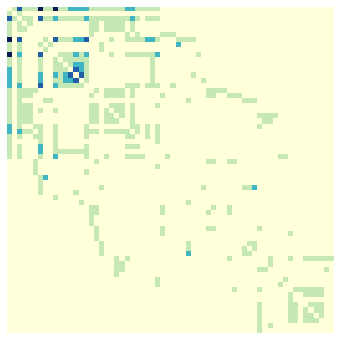

In [17]:
m = MatrixPlot(G)
m.draw()
plt.show()

<b><i>The hearth of a graph lies in its edges, not in its nodes</i></b><br>
<i>- John Quackenbush Harvard School of Public Health</i>

In [18]:
pred_jc = nx.jaccard_coefficient(G)
pred_jc_dict = {}
for u,v,p in pred_jc:
    pred_jc_dict[(u,v)] = p
sorted(pred_jc_dict.items(),key=lambda x:x[1], reverse=True)[:10]

[((42, 43), 1.0),
 ((28, 30), 0.6153846153846154),
 ((2, 9), 0.5),
 ((34, 35), 0.5),
 ((35, 37), 0.5),
 ((61, 62), 0.5),
 ((47, 49), 0.45454545454545453),
 ((26, 27), 0.4),
 ((11, 28), 0.38461538461538464),
 ((12, 28), 0.38461538461538464)]